# SIMULACIÓN DE DATOS WEARABLE TERCER TRIMESTRE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.interpolate import UnivariateSpline

import scipy.stats as stats
import seaborn as sns
from scipy.interpolate import interp1d

from datetime import date
from datetime import datetime
from datetime import timedelta

En esta sección vamos a terminar de modelar los cambios que el wearable debería captar en las últimas semanas del embarazo.

<ol>
    <li>DiastolicBP y SystolicBP:
        <ul>
            <li>Primer trimestre (0-14): disminución inicial debido a hormonas.</li>
            <li>Segundo trimestre (14-26): alcanza valores más bajos y tiende a estabilizarse.</li>
            <li>Tercer trimestre (27-40): aumenta, sube más que en primeras semanas.</li>
        </ul>
    </li>
    <li>Blood Sugar:
        <ul>
            <li>Primer trimestre: tendencia a hipoglucemia.</li>
            <li>Segundo Trimestre: aumento a resistencia a insulina, elevan niveles de glucosa en sangre.</li>
            <li>Tercer trimestre: se mantiene a nivel del 2do trimestre.</li>
        </ul>
    </li>
    <li>Body Temperature:
        <ul>
            <li>Primer trimestre: suele ser más alta a la normal (0,3-0,4 ºC más, pero se mantiene alrededor de 37 ºC).</li>
            <li>Segundo trimestre: tiende a estabilizarse y regresar a niveles previos al embarazo.</li>
            <li>Tercer trimestre: mantiene niveles 2do trimestre.</li> 
        </ul>
    </li>
    <li>HeartRate:
        <ul>
            <li>Primer trimestre: aumento FC, en reposo es 10 lpm mayor a lo normal</li>
            <li>Segundo trimestre: aumenta FC: incrementa 15 lpm respecto a lo normal,, mayor volumen sanguíneo y mayor retorno venoso. </li>
            <li>Tercer trimestre: pico máximo FC, aumenta 10-20 más en comparación a segundo trimestre.</li> 
        </ul>
    </li>
</ol>


In [3]:
ST = pd.read_csv("SecondTrimester-complete.csv")

In [5]:
#Agregamos columna para calcular semanas
def calculate_weeks(df, user_col = 'user_id', day_col='timestamp', start_date = '2024-06-01 14:38:44'):
    """
    Calcula la semana en la que se encuentra del emebarazo para cada usuario
    ARGS:
        - data (pd.DataFrame): dataframe
        - user_col (str): nombre de la columna con los ids de los usuarios
        - day_col (datetime): nombre de la columna con las fechas
    RETURNS:
        - dataframe con columna adicional "week" (int).
    """
    data = df.copy()
    data[day_col] = pd.to_datetime(data[day_col], errors = 'coerce')
    start_date = pd.to_datetime(start_date)
#calcula las semanas desde el inicio
    data['week'] = ((data[day_col] - start_date).dt.days // 7) +1
    return data



**Modelos de simulación**

In [7]:
def stabilize_pattern(start_week, end_week, start_value, stable_value, current_week):
    """
    Simulación de la estabilización  por medio de una función exponencial. 
    Depende de la semana en la que se encuentra, si aún está en el semanas que corresponden 
    al primer trimestre, no se modela nada, en cambio si están en el tercer trimestre, el valor se mantendrá. 
    De lo contrario, se modela cambio. 

    ARGS:
        - start week (int): semana de gestación que empieza  trimestre.
        - end_week (int): última semana de gestación  del trimestre.
        - stable_value (float): valor que se mantiene si está fuera del rtimestre de interés.
        - current_week(int): semana de gestación en la wue se encuentra usuario.
    RETURNS:
        - value (float): valor modificado, estable o de inicio según los casos anteriores.
    
    """
    if current_week < start_week:
        return start_value
    elif current_week > end_week:
        return stable_value
    else:
        k = -np.log(0.1) / (end_week - start_week)
        return start_value + (stable_value - start_value) * (1 - np.exp(-k*(current_week - start_week)))

In [9]:
def linear_increase_pattern(start_week, increment_per_week, base_value, current_week):
    """
    Modela cambios lineares. 
    - start_week(int): semana de gestación que empieza  trimestre.
    - increment_per_week(int): incremento a modelar por semana. 
    - base_value(int): valor donde empezamosa modelar. 
    - current week(int): semana actual de gestación. 
    """
    if current_week < start_week:
        return base_value
    else:
        return base_value + increment_per_week*(current_week - start_week)

In [11]:
def quadratic_increase(start_week, peak_week, end_week, min_value, max_value, current_week):
    """
    Modelo cuadrático para el aumento de la presión arterial en el tercer trimestre. 
    ARGS:
        - start_week(int): semana de gestación que empieza  trimestre.
        - peak_weak (int):  semana donde4 la presión alcanza valor máximo
        - min_value(int): valor inicial prsión arterial. 
        - max_value(int): valor máximo presión arterial. 
        - currentweek (int): semana actual. 
    RETURNS:
    - value: valor de la presión arterial modificado. 
    """
    if current_week < start_week:
        return min_value
    elif current_week > end_week:
        return max_value
    else:
        a = (max_value - min_value) / ((peak_week - start_week )**2)
        return min_value + a*(current_week - start_week)**2


In [13]:
ST.describe()

,Age,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate,week
count,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000,1411.000000
mean,31.482636,65.785977,110.760069,5.814334,98.465435,105.771439,17.847626
std,2.995780,3.091089,3.071685,1.741522,0.156965,3.434084,2.289390
min,19.000000,64.984375,105.000000,3.375000,98.090000,100.000000,14.000000
25%,32.000000,65.003506,110.003658,4.200000,98.417743,104.500000,17.000000
50%,32.000000,65.085938,110.078125,5.575000,98.506107,104.500000,17.000000
75%,32.000000,65.105469,110.105469,5.575000,98.506107,106.000000,18.000000
max,45.000000,93.000000,140.000000,13.000000,98.900000,118.000000,26.000000


In [15]:
ST.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1411 entries, 0 to 1410
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   user_id      1411 non-null   object 
 1   Age          1411 non-null   int64  
 2   timestamp    1411 non-null   object 
 3   DiastolicBP  1411 non-null   float64
 4   SystolicBP   1411 non-null   float64
 5   BS           1411 non-null   float64
 6   BodyTemp     1411 non-null   float64
 7   HeartRate    1411 non-null   float64
 8   day          1411 non-null   object 
 9   month&year   1411 non-null   object 
 10  date         1411 non-null   object 
 11  week         1411 non-null   int64  
 12  trimester    1411 non-null   object 
dtypes: float64(5), int64(2), object(6)
memory usage: 143.4+ KB


In [17]:
from datetime import timedelta
#nos aseguramos que timestamp esté en formato datetime
ST['timestamp'] = pd.to_datetime(ST['timestamp'])

#calcular la diferencia temporal  deseada, desde 02/12/2024 hasta 02/03/2025
shift_days = (pd.Timestamp('2025-03-02') - pd.Timestamp('2024-12-02')).days #extensión temporal que copiamos para el segundo trimestre
print(shift_days)
#reajustamos


thirdTrimester = ST.copy()
thirdTrimester['timestamp'] = thirdTrimester['timestamp'] + pd.to_timedelta(shift_days, unit='d')
thirdTrimester['day'] = thirdTrimester['timestamp'].dt.date
thirdTrimester['month&year'] = thirdTrimester['timestamp'].dt.to_period('M').astype(str)
thirdTrimester['date'] = thirdTrimester['timestamp'].dt.date
thirdTrimester = calculate_weeks(thirdTrimester, 'user_id', 'timestamp', '2024-12-02 14:38:44')
thirdTrimester.head()

90


,user_id,Age,timestamp,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate,day,month&year,date,week,trimester
0,user_0000,32,2024-12-16 02:45:05,65.936443,110.936443,7.5,98.613163,103.0,2024-12-16,2024-12,2024-12-16,2,Segundo Trimeste
1,user_0000,32,2024-12-16 10:45:05,65.858406,110.780369,7.5,98.613163,103.0,2024-12-16,2024-12,2024-12-16,2,Segundo Trimeste
2,user_0000,32,2024-12-16 18:45:05,65.858406,110.780369,7.5,98.613163,103.0,2024-12-16,2024-12,2024-12-16,3,Segundo Trimeste
3,user_0000,31,2024-12-18 07:37:54,65.858406,110.897424,7.5,98.613163,103.0,2024-12-18,2024-12,2024-12-18,3,Segundo Trimeste
4,user_0000,31,2024-12-18 15:37:54,65.819387,110.819387,7.5,98.613163,103.0,2024-12-18,2024-12,2024-12-18,3,Segundo Trimeste


In [19]:

thirdTrimester['DiastolicBP'] = thirdTrimester.apply(
    lambda row: quadratic_increase(27, 33, 42, row['DiastolicBP'], 120, row['week']), axis=1
)

thirdTrimester['SystolicBP'] = thirdTrimester.apply(
    lambda row: quadratic_increase(27, 33, 42, row['SystolicBP'], 160, row['week']), axis=1
)
thirdTrimester['BS'] = thirdTrimester.apply(
    lambda row: stabilize_pattern(27, 42, row['BS'], 7, row['week']), axis=1
)
thirdTrimester['BodyTemp'] = thirdTrimester['week'].apply(
    lambda x: stabilize_pattern(27, 42, 98.9, 98, x))
thirdTrimester['HeartRate'] = thirdTrimester['week'].apply(
    lambda x: linear_increase_pattern(14, 1.5, 100, x))

In [21]:
def verifica_rango(dataframe):
    
    rangos_limites = {
        'SystolicBP': (70,200),
        'DiastolicBP':(40,120),
        'BodyTemp': (82,106.5),
        'BS':(2.22,33.3),
        'HeartRate':(30,200),
    }
    
    results= {}
    for col, (min_val, max_val) in rangos_limites.items():
        if col in dataframe.columns:
            
            validos = dataframe[(dataframe[col] >= min_val) & (dataframe[col] <= max_val)]
            fuera_rango = len(dataframe) - len(validos)
            results[col] = {
                'val_fuera_rango':fuera_rango,
                'total_filas': len(dataframe), 
                'valores_validos': len(validos)
            }

    for col, info in results.items():
        print(f"- Valores fuera del rango de {col}:{info['val_fuera_rango']}\n")
        print(f"- Total valores de {col}:{info['total_filas']}\n")
        print(f"- Valores validos de {col}: {info['valores_validos']}\n")
    

In [23]:
verifica_rango(thirdTrimester)

- Valores fuera del rango de SystolicBP:0

- Total valores de SystolicBP:1411

- Valores validos de SystolicBP: 1411

- Valores fuera del rango de DiastolicBP:0

- Total valores de DiastolicBP:1411

- Valores validos de DiastolicBP: 1411

- Valores fuera del rango de BodyTemp:0

- Total valores de BodyTemp:1411

- Valores validos de BodyTemp: 1411

- Valores fuera del rango de BS:0

- Total valores de BS:1411

- Valores validos de BS: 1411

- Valores fuera del rango de HeartRate:0

- Total valores de HeartRate:1411

- Valores validos de HeartRate: 1411



In [25]:
def dropOutliers(dataframe):
    rangos= {
        'Age': (15, 60),
        'BodyTemp': (82, 106.5),  
        'BS': (2.2, 33.3),  
        'SystolicBP': (70, 180),  
        'DiastolicBP': (40, 120) , 
        'HeartRate': (37, 160)
    }
    for columna, (min_val, max_val) in rangos.items():
        if columna in dataframe.columns:
            dataframe = dataframe[(dataframe[columna] >= min_val) & (dataframe[columna] <= max_val)]
    return dataframe

In [27]:
thirdTrimester= dropOutliers(thirdTrimester)

In [29]:
thirdTrimester.describe()

,Age,timestamp,DiastolicBP,SystolicBP,BS,BodyTemp,HeartRate,week
count,1411.000000,1411,1411.000000,1411.000000,1411.000000,1.411000e+03,1411.0,1411.000000
mean,31.482636,2024-12-29 20:40:21.641388800,65.785977,110.760069,5.814334,9.890000e+01,100.0,4.372077
min,19.000000,2024-12-01 14:38:44,64.984375,105.000000,3.375000,9.890000e+01,100.0,0.000000
25%,32.000000,2024-12-21 17:37:35.500000,65.003506,110.003658,4.200000,9.890000e+01,100.0,3.000000
50%,32.000000,2024-12-26 04:40:27,65.085938,110.078125,5.575000,9.890000e+01,100.0,4.000000
75%,32.000000,2024-12-29 18:58:57.500000,65.105469,110.105469,5.575000,9.890000e+01,100.0,4.000000
max,45.000000,2025-02-26 02:45:05,93.000000,140.000000,13.000000,9.890000e+01,100.0,13.000000
std,2.995780,NaN,3.091089,3.071685,1.741522,2.615724e-12,0.0,2.226160


In [ ]:
# Visualizar los cambios usando líneas para resaltar tendencias temporales
plt.figure(figsize=(18, 10))

# Diastolic and Systolic BP
plt.subplot(2, 2, 1)
plt.scatter(thirdTrimester['week'], thirdTrimester['DiastolicBP'], label="Diastolic BP", color="blue", marker="o")
plt.scatter(thirdTrimester['week'], thirdTrimester['SystolicBP'], label="Systolic BP", color="cyan", marker="o")
plt.title("Blood Pressure Trends")
plt.xlabel("Week")
plt.ylabel("BP (mmHg)")
plt.legend()

# Blood Sugar
plt.subplot(2, 2, 2)
plt.scatter(thirdTrimester['week'], thirdTrimester['BS'], label="Blood Sugar", color="orange", marker="o")
plt.title("Blood Sugar Trends")
plt.xlabel("Week")
plt.ylabel("Blood Sugar (mmol/l)")
plt.legend()

# Body Temperature
plt.subplot(2, 2, 3)
plt.scatter(thirdTrimester['week'], thirdTrimester['BodyTemp'], label="Body Temp", color="green", marker="o")
plt.title("Body Temperature Trends")
plt.xlabel("Week")
plt.ylabel("Body Temp (ºF)")
plt.legend()
# Heart Rate
plt.subplot(2, 2, 4)
plt.scatter(thirdTrimester['week'], thirdTrimester['HeartRate'], label="Heart Rate", color="red", marker="o")
plt.title("Heart Rate Trends")
plt.xlabel("Week")
plt.ylabel("Heart Rate (bpm)")
plt.legend()

## COMPARACIÓN SIGNOS VITALES ENTRE TRIMESTRES

In [31]:
# Abrir y cargar el fichero JSON
FT= pd.read_csv('firstTrimester_EXPANDED.csv')

# Mostrar el DataFrame
print(FT)

       user_id  Age            timestamp  DiastolicBP  SystolicBP     BS  \
0    user_0001   20  2024-01-07 02:45:05           85         130  11.11   
1    user_0001   20  2024-01-07 10:45:05           85         130  11.11   
2    user_0001   20  2024-01-07 18:45:05           85         130  11.11   
3    user_0001   25  2024-01-08 02:45:05           85         129   8.70   
4    user_0001   25  2024-01-08 10:45:05           85         129   8.70   
..         ...  ...                  ...          ...         ...    ...   
237  user_0031   27  2024-09-08 02:45:05           90         124   8.50   
238  user_0031   27  2024-09-08 10:45:05           91         125   8.56   
239  user_0031   27  2024-09-08 18:45:05           91         125   8.56   
240  user_0031   27  2024-10-08 02:45:05           92         126   8.61   
241  user_0031   27  2024-10-08 10:45:05           92         126   8.61   

       BodyTemp  HeartRate         day month&year        date  week  
0     98.020946  

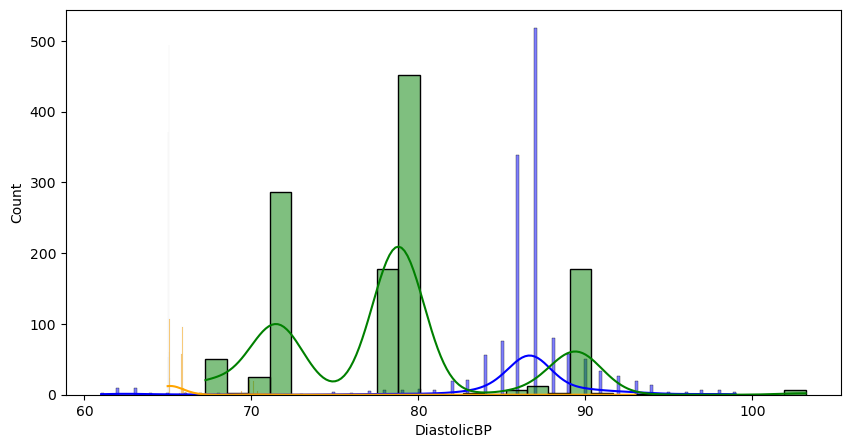

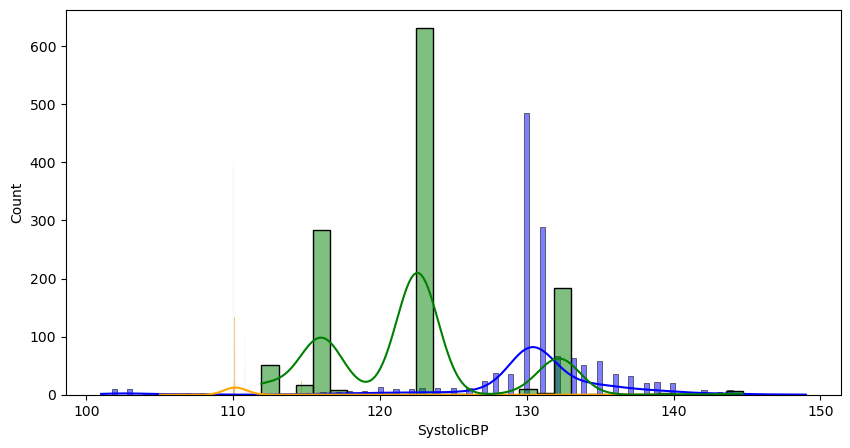

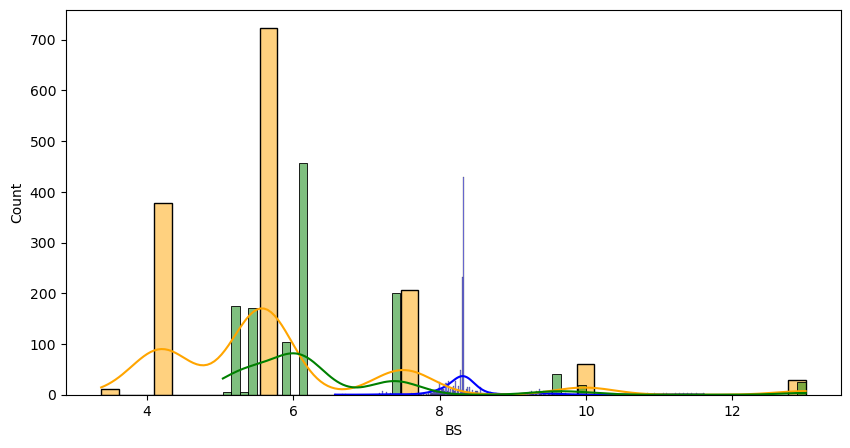

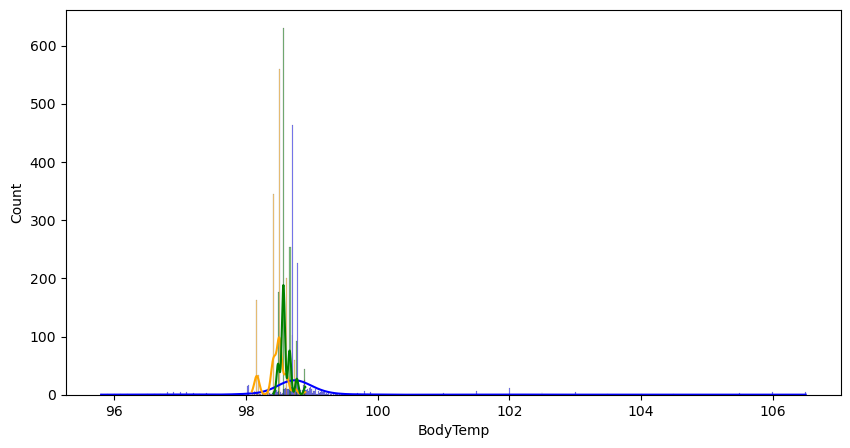

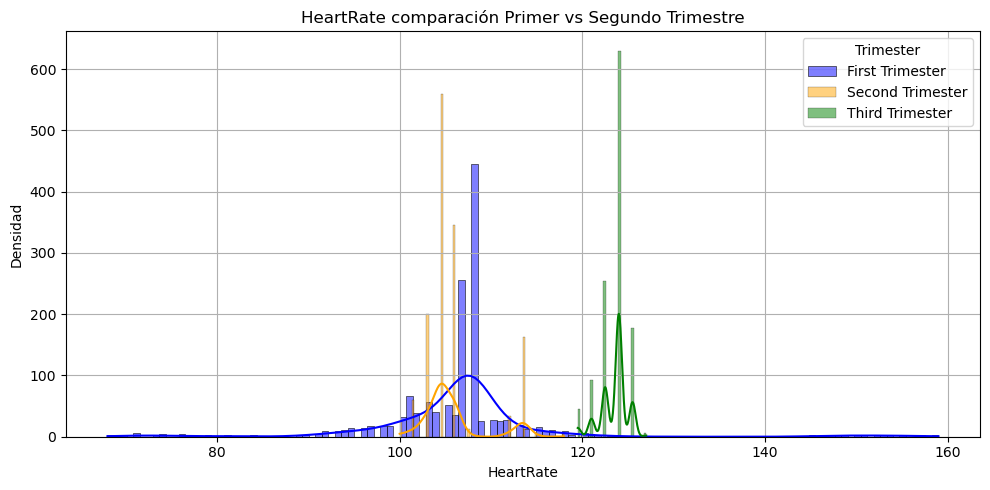

In [218]:
vital_signs = ['DiastolicBP', 'SystolicBP', 'BS', 'BodyTemp', 'HeartRate']
FT['trimester'] = 'Primer trimestre'
ST['trimester'] = 'Segundo Trimestre'
thirdTrimester['trimester'] = 'Tercer Trimestre'


for sign in vital_signs:
    plt.figure(figsize=(10,5))

    sns.histplot(data = FT, x=sign, label="First Trimester", color = 'blue', kde = True)
    sns.histplot(data = ST, x=sign, label="Second Trimester", color = 'orange', kde = True)
    sns.histplot(data = thirdTrimester, x=sign, label="Third Trimester", color = 'green', kde = True)

plt.title(f"{sign} comparación Primer vs Segundo Trimestre")
plt.xlabel(sign)
plt.ylabel("Densidad")
plt.legend(title="Trimester")
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
thirdTrimester.to_csv('ThirdTrimester-complete.csv', index=False)